<a href="https://colab.research.google.com/github/PinChunPai/Cat_breeds_classification/blob/main/colab/To_Web_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Web App**
In the other two ipynb I defined, trained and uploaded models. In this part I am going to examine whether the uploaded model works and use it to construct a web app available to public.

## **Fundamental setup**

In [1]:
## Fundamental packages for reading/writing files, algebra and plot
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 ### used for reading/writing images
import warnings
warnings.filterwarnings("ignore") ## ignore annoying warnings
from sklearn.model_selection import train_test_split ## For data preprocess

In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

In [3]:
!pip install transformers==4.24.0
!pip install evaluate==0.3.0
!pip install gradio==3.12.0

  Using cached gradio-3.12.0-py3-none-any.whl (11.6 MB)
  Attempting uninstall: gradio
    Found existing installation: gradio 4.14.0
    Uninstalling gradio-4.14.0:
      Successfully uninstalled gradio-4.14.0


In [4]:
path = '/content/drive/MyDrive/Project/Transformer_CV' ## It should be modified to the ACTUAL PATH storing dataset.

## **Download and test uploaded model**

In [5]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
model_id = "PinChunPai/cat20_breed_fine_tune"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForImageClassification.from_pretrained(model_id).to(device)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

We have to preprocess images before using the model. The following customed feature extractor is exactly the test_transform I used in training process.

In [6]:
image_preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])

Test the model on our dataset.

In [129]:
all_data = pd.read_csv(os.path.join(path, 'labels.csv'))
all_data['id'] = path + '/cats20/' + all_data['id']
all_data.head()

,id,breed
0,/content/drive/MyDrive/Project/Transformer_CV/...,Munchkin / 曼赤肯貓
1,/content/drive/MyDrive/Project/Transformer_CV/...,American Curl / 美國卷耳貓
2,/content/drive/MyDrive/Project/Transformer_CV/...,Birman / 伯曼貓
3,/content/drive/MyDrive/Project/Transformer_CV/...,Russian Blue / 俄羅斯藍貓
4,/content/drive/MyDrive/Project/Transformer_CV/...,Munchkin / 曼赤肯貓


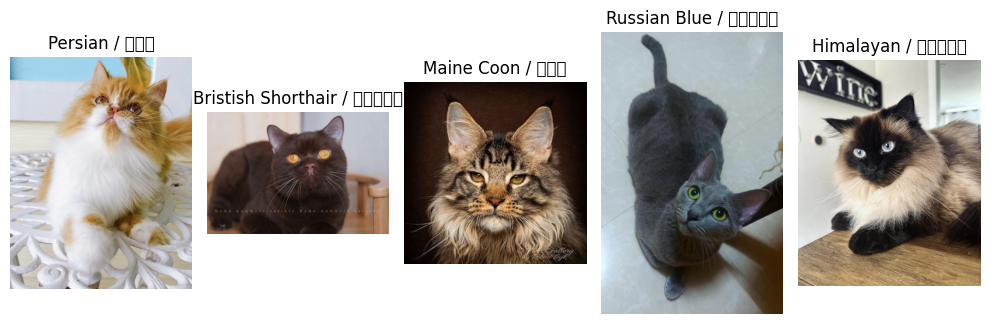

In [9]:
from matplotlib.font_manager import FontProperties
random_index = [1234, 5643,7705,8864,9321]
plt.figure(figsize=(10, 10))
for i in range(5):
   plt.subplot(1, 5, i + 1)
   img = Image.open(all_data.loc[[random_index[i]], "id"].values[0] )
   plt.imshow(img)
   plt.axis('off')
   plt.title(all_data.loc[[random_index[i]], "breed"].values[0])

plt.tight_layout()
plt.show()

Unfortunately, the Mandarin part becomes a mess. It would not be a problem because the maps equipped in model only contain English part.

In [137]:
id2label=model.config.id2label
print(model.config.id2label.values())
print(model.config.label2id.keys())

dict_values(['Munchkin', 'American Curl', 'Birman', 'Russian Blue', 'Bristish Shorthair', 'Exotic Shorthair', 'Norwegian Forest', 'Scottish Fold', 'Ragdoll', 'Himalayan', 'Bombay', 'Maine Coon', 'Abyssinian', 'American Shorthair', 'Bengal', 'Egyptian Mau', 'Sphynx', 'Persian', 'Siamese', 'Manx'])
dict_keys(['Abyssinian', 'American Curl', 'American Shorthair', 'Bengal', 'Birman', 'Bombay', 'Bristish Shorthair', 'Egyptian Mau', 'Exotic Shorthair', 'Himalayan', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest', 'Persian', 'Ragdoll', 'Russian Blue', 'Scottish Fold', 'Siamese', 'Sphynx'])


Test whether the model works.

In [139]:
img = Image.open(all_data.loc[[1234], "id"].values[0] )
image = image_preprocess(img)
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    logits = model(image).logits
prediction = torch.softmax(logits, dim=1)
print(prediction)

tensor([[7.6125e-05, 7.2673e-06, 3.2455e-06, 1.8134e-09, 1.6925e-05, 3.5371e-04,
         7.6019e-06, 6.5987e-06, 4.9052e-06, 2.1755e-05, 8.6509e-08, 1.9145e-05,
         5.9319e-07, 2.3864e-08, 5.1587e-08, 3.2975e-07, 1.7415e-07, 9.9948e-01,
         1.3759e-07, 2.0411e-07]])


To make real prediction we have to use softmax. I want to keep the highest two possibilities and put all remaining to others.

In [140]:
top_indices = torch.argsort(prediction, descending=True)[:].tolist()
top1 = round(100 * prediction[0][top_indices[0][0]].item(), 2)
top2 = round(100 * prediction[0][top_indices[0][1]].item(), 2)
others = round(100 - top1 - top2,2)  # Calculate the percentage for 'others'

# Print the results
len_1 = len(id2label[top_indices[0][0]])
len_2 = len(id2label[top_indices[0][1]])

# Find the maximum length among the labels
max_length = max(len_1 , len_2, len('Others'))

# Print the aligned results
label1 = f'{id2label[top_indices[0][0]]}'.ljust(max_length) + f" : {top1}%"
label2 = f'{id2label[top_indices[0][1]]}'.ljust(max_length) + f" : {top2}%"
label_others = f'Others'.ljust(max_length) + f" : {others}%"

# Print the vertically aligned results
print(label1)
print(label2)
print(label_others)

Persian          : 99.95%
Exotic Shorthair : 0.04%
Others           : 0.01%


Take a look at the actually pictiure and ground truth.

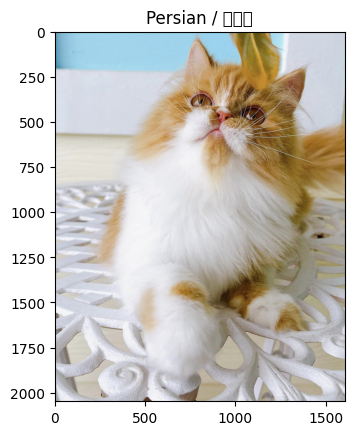

In [143]:
plt.imshow(img)
plt.title(all_data.loc[[1234], "breed"].values[0])
plt.show()

## **Define Classifier**

Now we can integrate all these into a single function, called clasified

In [144]:
def classifier(image):
    image = image_preprocess(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
      logits = model(image).logits

    prediction = torch.softmax(logits, dim=1)

    # Get the top indices and percentages
    top_indices = torch.argsort(prediction, descending=True)[:].tolist()
    top1 = round( prediction[0][top_indices[0][0]].item(), 4)
    top2 = round( prediction[0][top_indices[0][1]].item(), 4)
    others = round(1.0 - top1 - top2, 4)

    # Find the maximum length among the labels
    len_1 = len(id2label[top_indices[0][0]])
    len_2 = len(id2label[top_indices[0][1]])
    max_length = max(len_1, len_2, len('Others'))

    # Create a formatted string with the classification results
    labels = [f'{id2label[top_indices[0][0]]}'.ljust(max_length), f'{id2label[top_indices[0][1]]}'.ljust(max_length), f'Others'.ljust(max_length)]
    preds = [top1, top2, others]
    result = {label : float(pred) for label, pred in zip(labels, preds)}

    # Return the formatted string
    return result

In [145]:
for key, value in classifier(Image.open(all_data.loc[[7705], "id"].values[0] )).items():
    print( key, value)
print('Ground Truth: ', all_data.loc[[7705], "breed"].values[0])

Maine Coon       0.9589
Norwegian Forest 0.0406
Others           0.0005
Ground Truth:  Maine Coon / 緬因貓


In [146]:
for key, value in classifier(Image.open(all_data.loc[[8864], "id"].values[0] )).items():
     print( key, value)
print('Ground Truth: ', all_data.loc[[8864], "breed"].values[0])

Russian Blue 0.9726
Sphynx       0.0077
Others       0.0197
Ground Truth:  Russian Blue / 俄羅斯藍貓


In [147]:
for key, value in classifier(Image.open(all_data.loc[[9321], "id"].values[0] )).items():
     print( key, value)
print('Ground Truth: ', all_data.loc[[9321], "breed"].values[0])

Himalayan 0.9939
Birman    0.0024
Others    0.0037
Ground Truth:  Himalayan / 喜馬拉雅貓


Our classifier works on all of them. It's not surprising because all these images come from the dataset used to train our model. I am going to use gradio to create a web app so this model can be tested on more images and get the feedback of how to improve.

## **Gradio**

After checking the model works, we can use gradio to design the inference and then save the app to HuggingFace.

### **Install**

In [19]:
!pip install --upgrade httpx

  Using cached httpx-0.26.0-py3-none-any.whl (75 kB)
  Using cached httpcore-1.0.2-py3-none-any.whl (76 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.12.0
    Uninstalling h11-0.12.0:
      Successfully uninstalled h11-0.12.0
  Attempting uninstall: httpcore
    Found existing installation: httpcore 0.15.0
    Uninstalling httpcore-0.15.0:
      Successfully uninstalled httpcore-0.15.0
  Attempting uninstall: httpx
    Found existing installation: httpx 0.25.1
    Uninstalling httpx-0.25.1:
      Successfully uninstalled httpx-0.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 3.12.0 requires h11<0.13,>=0.11, but you have h11 0.14.0 which is incompatible.


In [20]:
!pip install --upgrade gradio

  Using cached gradio-4.14.0-py3-none-any.whl (16.6 MB)
  Attempting uninstall: gradio
    Found existing installation: gradio 3.12.0
    Uninstalling gradio-3.12.0:
      Successfully uninstalled gradio-3.12.0


In [21]:
!pip install --upgrade gradio
import gradio as gr

In [83]:
!pip --version gradio

pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [84]:
!pip --version python

pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


### **Redefine Function**
I will upload the final app to HuggingFace, so let's carefully define the pipeline from scratch. One important thing to note is that gradio image has different format from what we used, so using the above classifier function will simply gives error. To solve this I add a condition to check whether the input is a Numpy array. This took me 2 hours to figure out the problem. It's a good lesson about ensuring we know how every parts of the project address files.

In [152]:
# Define the classifier function
def classifier_app(image):
    # Check if image is a NumPy array, or it will fail on gradio.
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'), 'RGB')


    image_preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    image = image_preprocess(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    model_id = "PinChunPai/cat20_breed_fine_tune"
    model = AutoModelForImageClassification.from_pretrained(model_id).to(device)
    model.eval()
    id2label=model.config.id2label

    with torch.no_grad():
      logits = model(image).logits

    prediction = torch.softmax(logits, dim=1)

    # Get the top indices and percentages
    top_indices = torch.argsort(prediction, descending=True)[:].tolist()
    top1 = round( prediction[0][top_indices[0][0]].item(), 4)
    top2 = round( prediction[0][top_indices[0][1]].item(), 4)
    others = round(1.0 - top1 - top2, 4)

    # Find the maximum length among the labels
    len_1 = len(id2label[top_indices[0][0]])
    len_2 = len(id2label[top_indices[0][1]])
    max_length = max(len_1, len_2, len('Others'))

    # Create a formatted string with the classification results
    labels = [f'{id2label[top_indices[0][0]]}'.ljust(max_length), f'{id2label[top_indices[0][1]]}'.ljust(max_length), f'Others'.ljust(max_length)]
    preds = [top1, top2, others]
    result = {label : float(pred) for label, pred in zip(labels, preds)}

    # Return the formatted string
    return result

Let's test it.

In [157]:
test_img = Image.open(all_data.loc[[7705], "id"].values[0] )
for key, value in classifier_app(Image.open(all_data.loc[[7705], "id"].values[0] )).items():
    print(key ,value)

Maine Coon       0.9589
Norwegian Forest 0.0406
Others           0.0005


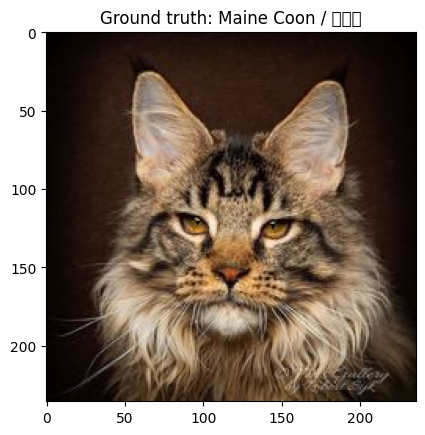

In [158]:
plt.imshow(test_img)
plt.title(f'Ground truth: {all_data.loc[[7705], "breed"].values[0]}')
plt.show()

In [159]:
# Create Gradio interface
interface = gr.Interface(
    fn=classifier_app,
    inputs="image",
    outputs="label",  # Use "text" component for displaying the formatted string
#    live=True  # Set to True for live updates
)
# Launch the interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cc4a4e57b11c6683e5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Perfect! The final step is to save this app to HuggingFace.